角点检测
===

# 1.角点
角点检测是检测边缘上的角点。

# 2.Hession角点检测
角点是曲率变大的点，下式定义了高斯曲率：
$$K=\frac{\det(H)}{(1+{I_x}^2+{I_y}^2)^2}$$
- $\det(H)=I_{xx}\ I_{yy}-{I_{xy}}^2$
- $H$表示Hessian矩阵。图像的二次微分（通过将Sobel滤波器应用于灰度图像计算得来）。对于图像上的一点，按照下式定义
$$
H=
\begin{bmatrix}
I_{xx}&I_{xy} \\
I_{xy}&I_{yy}
\end{bmatrix}
$$
$I_x$是应用$x$方向上的Sobel滤波器，$I_y$是应用在$y$方向上的Sobel滤波器

在Hessian角点检测中，detH将极大点视为j角点。如果中心像素与其8−近邻像素相比值最大，则中心像素为极大点。解答中，角点是$det(H)$为极大值，并且大于$max(det(H))⋅0.1$的点。

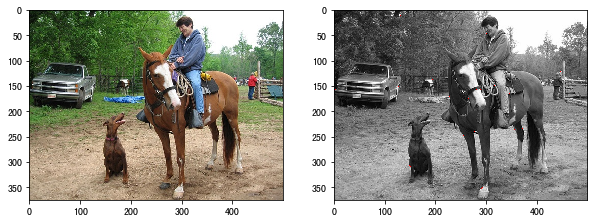

In [2]:
import cv2
import matplotlib.pyplot as plt
import skimage.util as su
import numpy as np

def Hessian_corner(img):

	## Grayscale
	def BGR2GRAY(img):
		gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]
		gray = gray.astype(np.uint8)
		return gray

	## Sobel
	def Sobel_filtering(gray):
		# get shape
		H, W = gray.shape

		# sobel kernel
		sobely = np.array(((1, 2, 1),
						(0, 0, 0),
						(-1, -2, -1)), dtype=np.float32)

		sobelx = np.array(((1, 0, -1),
						(2, 0, -2),
						(1, 0, -1)), dtype=np.float32)

		# padding
		tmp = np.pad(gray, (1, 1), 'edge')

		# prepare
		Ix = np.zeros_like(gray, dtype=np.float32)
		Iy = np.zeros_like(gray, dtype=np.float32)

		# get differential
		for y in range(H):
			for x in range(W):
				Ix[y, x] = np.mean(tmp[y : y  + 3, x : x + 3] * sobelx)
				Iy[y, x] = np.mean(tmp[y : y + 3, x : x + 3] * sobely)
			
		Ix2 = Ix ** 2
		Iy2 = Iy ** 2
		Ixy = Ix * Iy

		return Ix2, Iy2, Ixy

	## Hessian
	def corner_detect(gray, Ix2, Iy2, Ixy):
		# get shape
		H, W = gray.shape

		# prepare for show detection
		out = np.array((gray, gray, gray))
		out = np.transpose(out, (1,2,0))

		# get Hessian value
		Hes = np.zeros((H, W))

		for y in range(H):
			for x in range(W):
				Hes[y,x] = Ix2[y,x] * Iy2[y,x] - Ixy[y,x] ** 2

		## Detect Corner and show
		for y in range(H):
			for x in range(W):
				if Hes[y,x] == np.max(Hes[max(y-1, 0) : min(y+2, H), max(x-1, 0) : min(x+2, W)]) and Hes[y, x] > np.max(Hes) * 0.1:
					out[y, x] = [0, 0, 255]

		out = out.astype(np.uint8)

		return out

	# 1. grayscale
	gray = BGR2GRAY(img)

	# 2. get difference image
	Ix2, Iy2, Ixy = Sobel_filtering(gray)

	# 3. corner detection
	out = corner_detect(gray, Ix2, Iy2, Ixy)

	return out

img = cv2.imread("data/02.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,5), facecolor='w')
plt.subplot(1, 2, 1) 
plt.imshow(img)

out = Hessian_corner(img)
plt.subplot(1, 2, 2) 
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))


# 3.Harris角点检测

## 3.1.Harris角点检测第一步-Sobel+Gausian
- 对图像进行灰度化处理
- 利用Sobel滤波器求出海森矩阵(Hessian matrix)
$$
H=\begin{bmatrix}
{I_x}^2&I_xI_y \\
I_xI_y&{I_y}^2
\end{bmatrix}
$$
- 将高斯滤波器分别应用于$I_x^2,I_y^2,I_x,I_y$

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 499.5, 374.5, -0.5)

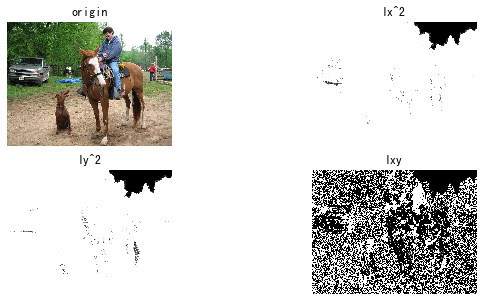

In [3]:
import cv2
import matplotlib.pyplot as plt
import skimage.util as su
import numpy as np

def Harris_corner_step1(img):
    def BGR2GRAY(img):
        gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]
        gray = gray.astype(np.uint8)
        return gray
    
    def Sobel_filtering(gray):
        H, W = gray.shape
        sobely = np.array(((1, 2, 1),(0, 0, 0),(-1, -2, -1)), dtype=np.float32)
        sobelx = np.array(((1, 0, -1),(2, 0, -2),(1, 0, -1)), dtype=np.float32)
        
        tmp = np.pad(gray, (1, 1), 'edge')
        Ix = np.zeros_like(gray, dtype=np.float32)
        Iy = np.zeros_like(gray, dtype=np.float32)
        
        for y in range(H):
            for x in range(W):
                Ix[y, x] = np.mean(tmp[y : y  + 3, x : x + 3] * sobelx)
                Iy[y, x] = np.mean(tmp[y : y + 3, x : x + 3] * sobely)
        
        Ix2 = Ix ** 2
        Iy2 = Iy ** 2
        Ixy = Ix * Iy
        return Ix2, Iy2, Ixy
    
    def gaussian_filtering(I, K_size=3, sigma=3):
        H, W = I.shape
        I_t = np.pad(I, (K_size // 2, K_size // 2), 'edge')
        K = np.zeros((K_size, K_size), dtype=np.float)
        for x in range(K_size):
            for y in range(K_size):
                _x = x - K_size // 2
                _y = y - K_size // 2
                K[y, x] = np.exp( -(_x ** 2 + _y ** 2) / (2 * (sigma ** 2)))
        K /= (sigma * np.sqrt(2 * np.pi))
        K /= K.sum()
        
        for y in range(H):
            for x in range(W):
                I[y,x] = np.sum(I_t[y : y + K_size, x : x + K_size] * K)
        return I

    gray = BGR2GRAY(img)
    Ix2, Iy2, Ixy = Sobel_filtering(gray)
    Ix2 = gaussian_filtering(Ix2, K_size=3, sigma=3)
    Iy2 = gaussian_filtering(Iy2, K_size=3, sigma=3)
    Ixy = gaussian_filtering(Ixy, K_size=3, sigma=3)
    return Ix2, Iy2, Ixy

img = cv2.imread("data/02.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,5), facecolor='w')
plt.subplot(2, 2, 1) 
plt.imshow(img)
plt.title("origin")
plt.axis("off")

out1, out2, out3 = Harris_corner_step1(img)

plt.subplot(2, 2, 2) 
plt.imshow(cv2.cvtColor(out1, cv2.COLOR_BGR2RGB), cmap='gray')
plt.title("Ix^2")
plt.axis("off")

plt.subplot(2, 2, 3) 
plt.imshow(cv2.cvtColor(out2, cv2.COLOR_BGR2RGB), cmap='gray')
plt.title("Iy^2")
plt.axis("off")

plt.subplot(2, 2, 4) 
plt.imshow(cv2.cvtColor(out3, cv2.COLOR_BGR2RGB), cmap='gray')
plt.title("Ixy")
plt.axis("off")

## 3.2.Harris角点检测第二步-角点检测
- 计算每个像素的$R=det(H)−k (trace(H))^2$。通常$K$在$[0.04,0.16]$范围内取值.
- 满足$R \geq max(R) \cdot th$的像素点即为角点。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 499.5, 374.5, -0.5)

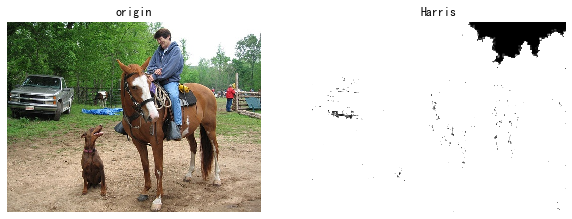

In [4]:
import cv2
import matplotlib.pyplot as plt
import skimage.util as su
import numpy as np

def Harris_corner(img):
    def BGR2GRAY(img):
        gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]
        gray = gray.astype(np.uint8)
        return gray
    
    def Sobel_filtering(gray):
        H, W = gray.shape
        sobely = np.array(((1, 2, 1),(0, 0, 0),(-1, -2, -1)), dtype=np.float32)
        sobelx = np.array(((1, 0, -1),(2, 0, -2),(1, 0, -1)), dtype=np.float32)
        
        tmp = np.pad(gray, (1, 1), 'edge')
        Ix = np.zeros_like(gray, dtype=np.float32)
        Iy = np.zeros_like(gray, dtype=np.float32)
        
        for y in range(H):
            for x in range(W):
                Ix[y, x] = np.mean(tmp[y : y  + 3, x : x + 3] * sobelx)
                Iy[y, x] = np.mean(tmp[y : y + 3, x : x + 3] * sobely)
        
        Ix2 = Ix ** 2
        Iy2 = Iy ** 2
        Ixy = Ix * Iy
        return Ix2, Iy2, Ixy
    
    def gaussian_filtering(I, K_size=3, sigma=3):
        H, W = I.shape
        I_t = np.pad(I, (K_size // 2, K_size // 2), 'edge')
        K = np.zeros((K_size, K_size), dtype=np.float)
        for x in range(K_size):
            for y in range(K_size):
                _x = x - K_size // 2
                _y = y - K_size // 2
                K[y, x] = np.exp( -(_x ** 2 + _y ** 2) / (2 * (sigma ** 2)))
        K /= (sigma * np.sqrt(2 * np.pi))
        K /= K.sum()
        
        for y in range(H):
            for x in range(W):
                I[y,x] = np.sum(I_t[y : y + K_size, x : x + K_size] * K)
        return I

    def corner_detect(gray, Ix2, Iy2, Ixy, k=0.04, th=0.1):
        out = np.array((gray, gray, gray))
        out = np.transpose(out, (1,2,0))
        R = (Ix2 * Iy2 - Ixy ** 2) - k * ((Ix2 + Iy2) ** 2)
        out[R >= np.max(R) * th] = [0, 0, 255]
        out = out.astype(np.uint8)
        return out
    
    gray = BGR2GRAY(img)
    Ix2, Iy2, Ixy = Sobel_filtering(gray)
    Ix2 = gaussian_filtering(Ix2, K_size=3, sigma=3)
    Iy2 = gaussian_filtering(Iy2, K_size=3, sigma=3)
    Ixy = gaussian_filtering(Ixy, K_size=3, sigma=3)
    out = corner_detect(gray, Ix2, Iy2, Ixy)
    
    return out

img = cv2.imread("data/02.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,5), facecolor='w')
plt.subplot(1, 2, 1) 
plt.imshow(img)
plt.title("origin")
plt.axis("off")

out = Harris_corner(img)

plt.subplot(1, 2, 2) 
plt.imshow(cv2.cvtColor(out1, cv2.COLOR_BGR2RGB), cmap='gray')
plt.title("Harris")
plt.axis("off")